## Problem

Starting point of kinetic theory is the notion of a distribution function. The distribution function is denoted as 
$$
f({\bf x}, \zeta, t)
$$ 
with ${\bf x}$ space vector, $\zeta$ velocity vector, and $t$ time. It can be seen as a generalization of the density $\rho({\bf x}, t)$, now also taking into account velocity. It is the density of molecules in physical space as well as in velocity space.

It is useful to make a distinction between random thermal motion (with velocity $v({\bf x}, t)$) and bulk motion of molecules (with velocity $u({\bf x}, t)$: $v({\bf x}, t) \equiv \zeta({\bf x}, t) − u({\bf x},t)$.

If a gas is left alone for sufficiently long time and molecules have undergone many collisions thereby exchanging momentum one can imagine that the distribution of velocities of the molecules reaches an equilibrium. This equilibrium is expected to be isotropic in velocity space. We assume – without lack of generality – the average velocity $u=0$ so that $v({\bf x}, t) \equiv \zeta({\bf x}, t)$. Isotropy in velocity space then means that only the velocity magnitude (not the direction) matters for the equilibrium distribution function: $f^eq ({\bf x}, |v| , t)$. An important result of statistical mechanics is that the equilibrium distribution has the following form:
$$
f^eq ({\bf x}, |v| , t) = \rho\left(\frac{1}{2\pi RT}\right)^{3/2} e^{-\frac{|v|^2}{2RT}}
$$
The evolution of this distribution is given by the 

The discretizations in time, space and velocity lead to the Boltzmann transport equation, which is
$$
\frac{\partial f}{\partial t} + \overrightarrow{u} \bigtriangledown f = \Omega
$$
where $f(\overrightarrow{x}, t)$ is the particle distribution function, $\overrightarrow{u}$ is the particle velocity, and $\Omega$ is the collision operator.

The simplest yet effective collision operator is the Bhatnagar, Gross & Krook (BGK) collision operator:
$$
\Omega(f) = -\frac{1}{\tau} (f - f^{eq})
$$

We use the Lattice Boltzmann method in order to solve the Boltzmann transport equation. In discret time, we solve
$$
f_i( x + c_i \Delta t, t + \Delta t) = f_i ( x , t ) + \Omega_i( x , t )
$$
where $c=\sqrt{1/3}\frac{\Delta x}{\Delta t}$ is the lattice speed. The discrete-time form of the collision operator is
$$
\Omega_i( x , t ) = \Omega_i ( f ) = -\frac{1}{\tau} (f_i − f_i^{eq} )
$$



### Basic idea
The LBM simplifies Boltzmann’s original idea of gas dynamics by reducing the number of particles and confining them to the nodes of a lattice. 

### Implementation
For a two dimensional model, a particle is restricted to stream in a possible of 9 directions, including the one staying at rest. These velocities are referred to as the microscopic velocities and denoted by $\overrightarrow{e}_i$, where $i = 0, . . . , 8$. 
This model is commonly known as the D2Q9 model as it is two dimensional and involves 9 velocity vectors, defined by
$$
\overrightarrow{e}_i = 
\left\{
\begin{array}{ll}
(0, 0), (0,-1), (0,1) & i=0,1,2\\
(-1, 0), (-1, -1), (-1, 1) & i=3,4,5\\  
(1, 0), (1, -1), (1, 1) & i=6, 7, 8
\end{array}\right.
$$
For each particle on the lattice, we associate a discrete probability distribution function $f_i(\overrightarrow{x}, \overrightarrow{e}_i , t)$ or simply $f_i (\overrightarrow{x}, t)$, $i = 0 . . . 8$, which describes the probability of streaming in one particular direction.

The macroscopic fluid density can be defined as a summation of microscopic particle distribution function,
$$
\rho(\overrightarrow{x},t) = \sum_{i=0}^8 f_i (\overrightarrow{x}, t)
$$
Accordingly, the macroscopic velocity $\overrightarrow{u}(\overrightarrow{x}, t)$ is an average of microscopic velocities $\overrightarrow{e}_i$ weighted by the distribution functions $f_i$,
$$
\overrightarrow{u}(\overrightarrow{x}, t) = \frac{1}{\rho} \sum_{i=0}^8 c f_i(\overrightarrow{x}, t) \overrightarrow{e}_i
$$

### Key steps of the LBM method
The key steps in LBM are the streaming and collision processes which are given by
$$
\underbrace{f_i(\overrightarrow{x} + c\overrightarrow{e}_i\Delta t, t+\Delta t) - f_i(\overrightarrow{x},t)}_{\hbox{Streaming}} = -\underbrace{\frac{1}{\tau}\left(f_i(\overrightarrow{x},t) - f^{eq}_i (\overrightarrow{x}, t) \right)}_{\hbox{Collision}}
$$
where $f_i^{eq}(\overrightarrow{x}, t)$ is the equilibrium distribution, and $\tau$ is considered as the relaxation time towards local equilibrium. 

For simulating single phase flows, we use Bhatnagar-Gross-Krook (BGK) collision, whose equilibrium distribution $f_i^{eq}$ is defined by
$$
f_i^{eq}(\overrightarrow{x}, t)= \rho \omega_i + \rho s_i(\overrightarrow{u}(\overrightarrow{x}, t))
$$
with 
$$
s_i(\overrightarrow{u}) = \omega_i \left(3\frac{\overrightarrow{e} \cdot \overrightarrow{u}}{c} + \frac{9}{2}\frac{(\overrightarrow{e} \cdot \overrightarrow{u})^2}{c^2} - \frac{3}{2}\frac{ \overrightarrow{u} \cdot \overrightarrow{u} }{c^2} \right)
$$ 
where the weights $\omega_i$ are constant over time. 

In [40]:
import timeit
import numpy as np
import numpy.linalg as nplin
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy.polynomial.polynomial import polyfit
import plotly.figure_factory as ff

# Definition 0 : Parameters

In [41]:
# Total number of time iterations
maxIter = 23000 
# Reynolds number
Re      = 65 # 5 26 65 220   
# Dimension of the lattice
nx = 520 
ny = 180
ly = ny-1
# velocity index
q  = 9
# Coordinates of the circular obstacle
cx = nx/4 
cy = ny/2 
r  = ny/9

### Relaxation parameter.
The kinematic viscosity of the lattice-Boltzmann fluid relates to the relaxation time according to 
\begin{equation}
\nu = c_s^2 \left(\tau -\frac{\Delta t}{2} \right) \nonumber
\end{equation}
where each velocity set comes with a constant $c_s$ that relates pressure with density: $p=c_s^2 \rho$. This is an (isothermal) ideal gas law with $\frac{\partial p}{\partial \rho} = c_s^2$ so that $c_s$ is the speed of sound. In the most common velocity sets, $c_s=\sqrt{1/3} \frac{\Delta x}{\Delta t}$, ie. $c_s = \sqrt{1/3} \frac{\Delta x}{\Delta t}$ in lattice units). 

Therefore, we deduce (with $\Delta t=1$)
$$
\nu = \frac{2\tau - 1}{6}~~~\Rightarrow~~ \tau = 3\nu + 1/2 
$$

In [42]:
# Velocity in lattice units
uLB     = 0.04
# Relaxation parameter
nulb  = uLB*r/Re     # kinematic viscosity (scale length for Reynolds nember = radius of cylinder) 
omega = 1/(3*nulb+0.5)

# Definition 1 : Dynamics of the inflow

In [43]:
# Exogenous velocity intlet 
vel = np.fromfunction(lambda d,x,y: (1-d)*uLB*(1.0+1e-4*np.sin(y/ly*2*np.pi)),(2,nx,ny))

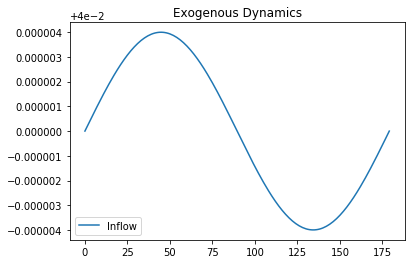

In [44]:
# plot of the inflow
toto = [uLB*(1+1e-4*np.sin(y/ly*2*np.pi)) for y in range(ny)]
plt.figure()
plt.plot(range(ny),toto,label='Inflow')
plt.legend(loc=3)
plt.title('Exogenous Dynamics')
plt.show()

In [45]:
vel.shape

(2, 520, 180)

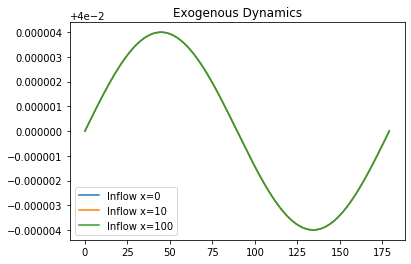

In [46]:
plt.figure()
plt.plot(range(ny),vel[0,0,:],label='Inflow x=0')
plt.plot(range(ny),vel[0,10,:],label='Inflow x=10')
plt.plot(range(ny),vel[0,100,:],label='Inflow x=100')
plt.legend(loc=3)
plt.title('Exogenous Dynamics')
plt.show()

# Definition 2 : the obstacle
Give the set of values inside the circle defined as the obstacle

In [47]:
obstacle = np.fromfunction(lambda x,y: (x-cx)**2+(y-cy)**2<r**2, (nx,ny))
# obstacle = boolean matrix 'True' within coordinates of obstacle
# np.fromfunction : Construct an array by executing a function over each coordinate.

# Lattice Constants

In [48]:
# matrix for the directions in 2D
c = np.array([(x,y) for x in [0,-1,1] for y in [0,-1,1]]) # Lattice velocities.
# Define the unknown when obstacle
i1 = np.arange(q)[np.asarray([ci[0]<0  for ci in c])] 
i2 = np.arange(q)[np.asarray([ci[0]==0 for ci in c])] 
i3 = np.arange(q)[np.asarray([ci[0]>0  for ci in c])] 

In [49]:
i1

array([3, 4, 5])

### This means that $f_3$, $f_4$ and $f_5$, are $f_{w}$, $f_{sw}$ and $f_{nw}$ respectively  

In [50]:
i2

array([0, 1, 2])

### This means that $f_0$, $f_1$ and $f_2$, are $f_{c}$, $f_{s}$ and $f_{n}$ respectively  

In [51]:
i3

array([6, 7, 8])

### This means that $f_6$, $f_7$ and $f_8$, are $f_{e}$, $f_{se}$ and $f_{ne}$ respectively  

In [52]:
c

array([[ 0,  0],
       [ 0, -1],
       [ 0,  1],
       [-1,  0],
       [-1, -1],
       [-1,  1],
       [ 1,  0],
       [ 1, -1],
       [ 1,  1]])

### The weights are
$$
\omega_i = \left\{
\begin{array}{rcl}
4/9 &\hbox{if}& i=0 ~~~(c)\\
1/9 &\hbox{if}& i=1,2,3,6~~~ (s,n,w,e)\\
1/36 &\hbox{if}& i=4,5,7,8~~~ (sw,nw,se,ne)\\
\end{array}\right.
$$

In [53]:
# weights when obstacle
t = np.array([4/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/9, 1/36, 1/36])

# Equilibrium distribution function
Equilibrium distribution is defined by
$$
f^{eq}_i = \rho \omega_i + \rho s_i(\overrightarrow{u})
$$
with 
$$
s_i(\overrightarrow{u}) = \omega_i \left(3\frac{\overrightarrow{e} \cdot \overrightarrow{u}}{c} + \frac{9}{2}\frac{\left(\overrightarrow{e} \cdot \overrightarrow{u}\right)^2}{c^2} - \frac{3}{2}\frac{ \overrightarrow{u} \cdot \overrightarrow{u} }{c^2} \right)
$$

In [54]:
def equilibrium(rho,u):             
    cu   = np.dot(c,u.transpose(1,0,2))
    usqr = u[0]**2+u[1]**2
    feq  = np.zeros((q,nx,ny))
    for i in range(q): 
        feq[i,:,:] = rho*t[i] + rho*t[i]*(3*cu[i] + (9/2)*cu[i]**2 - (3/2)*usqr)
    return feq

# Initial condition 

Initialization of $\rho$, $\overrightarrow{u}$, $f_i$ and $f_i^{eq}$.

In the following, we set 

1/ $\rho=1$ and $\overrightarrow{u}$="vel", the inlet exogenous velocity

2/ We then compute $f_i^{eq}$ using the "equilbrium" function and 

3/ set $f_i^{eq}=f_i$

In [55]:
# => output=(q,nx,ny) matrix
feq = equilibrium(1,vel)
fin = feq.copy()

In [56]:
fin.shape

(9, 520, 180)

In [57]:
fin[i1,-2,:].shape

(3, 180)

# Main time loop 

## Steps of the algorithm

1. Compute macroscopic $\rho$ and $\overrightarrow{u}$ from $f_i$ using
$$
\rho(\overrightarrow{x},t) = \sum_{i=0}^8 f_i (\overrightarrow{x}, t)~~~~~~~~~~~~~~~(1)
$$
$$
\overrightarrow{u}(\overrightarrow{x}, t) = \frac{1}{\rho} \sum_{i=0}^8 c f_i(\overrightarrow{x}, t) \overrightarrow{e}_i~~~~~(2)
$$

2. Compute $f_i^{eq}$ using 
$$
f^{eq}_i = \rho \omega_i + \rho s_i(\overrightarrow{u})~~~\hbox{with}~~~s_i(\overrightarrow{u}) = \omega_i \left(3\frac{\overrightarrow{e} \cdot \overrightarrow{u}}{c} + \frac{9}{2}\frac{(\overrightarrow{e} \cdot \overrightarrow{u})^2}{c^2} - \frac{3}{2}\frac{ \overrightarrow{u} \cdot \overrightarrow{u} }{c^2} \right)
$$

3. Collision step: calculate the updated distribution function 
$$
f_i^* = f_i - \frac{1}{\tau} (f_i - f_i^{eq} )
$$
using 
$$
f_i(\overrightarrow{x} + c\overrightarrow{e}_i\Delta t, t+\Delta t) = f_i(\overrightarrow{x},t) -\frac{f_i(\overrightarrow{x},t) - f^{eq}_i (\overrightarrow{x}, t)}{\tau}
$$

4. Streaming step: move $f_i^*$ $\rightarrow$ $f_i$ in the direction of $\overrightarrow{e}_i$

5. Repeat step 1 to 4

### Step 1
we compute 

1. $\rho$ using $\rho = \sum_a f_a$ $\Leftrightarrow$ rho = sumpop(fin)

2. $u$ using $\rho u = \sum_a e_a f_a$ $\Leftrightarrow$ $u = \frac{\sum_a e_a f_a}{\rho}$ 
$\Leftrightarrow$ u   = np.dot(c.transpose(), fin.transpose((1,0,2)))/rho

### Step 2 
$f^{eq}$ is given by: feq = equilibrium(rho,u)

### Step 3
The new value of $f_i$ is given by fout = fin - omega * (fin - feq)

### Step 4
Move $f_i^*$ $\rightarrow$ $f_i$: we shift ("stream") the post-collision distribution $f_i^*$ from its current location $x$ to its neighbouring location $x + c_i$ thereby advancing time by one time unit and taking into acccount the direction specific to each location. 

### Boudary Conditions

Using the two previous equations, the idea of Zou-He is to formulate a linear system. we consider that the velocity $\overrightarrow{u}_L = (u, v)$ is given on the left boundary. 

We first determine $f_6$ , $f_7$ , $f_8$ and $\rho$ using (1) and (2) that gives, after rearranging:
\begin{eqnarray*}
f_6  + f_7 + f_8 &=& \rho - (f_0 + f_1 + f_2 + f_3 + f_4 + f_5) ~~~~(1)\\
f_6 + f_7 + f_8 &=& \rho u + (f_3 + f_4 + f_5 )~~~~~~~~~~~~~~~~~~~~~~~~~~(2)\\
f_7 − f_8 &=& \rho v − f_1 + f_2 − f_4 + f_5 
\end{eqnarray*}
By considering (1) and (2), we can determine
$$
\rho = \frac{1}{1-u} (f_0 + f_1 + f_2 + 2(f_3 + f_4 + f_5 )~~~~~ (BC1)
$$
However, we need a fourth equation to close the system and solve for $f_6$, $f_7$ and $f_8$. 
The assumption made by Zou and He is that the bounce-back rule still holds for the non-equilibrium part of the particle distribution normal to the boundary. In this case, the fourth equation is
\begin{eqnarray*}
\left.\begin{array}{rcl}
f_3 − f_3^{eq} &=& f_6 − f_6^{eq} \\
f_4 − f_4^{eq} &=& f_7 − f_7^{eq} \\
f_5 − f_5^{eq} &=& f_8 − f_8^{eq} 
\end{array}\right\} ~~~~~ (BC2)
\end{eqnarray*}


# Test: time as a function of number of iterations

In [58]:
timel = np.zeros(maxIter//100)
iterl = np.zeros(maxIter//100)
start = timeit.default_timer()
print('Re = ', Re)
for Iter in range(maxIter):
    #-------------------
    # Initialisation
    #-------------------
    fin[i1,-1,:] = fin[i1,-2,:]      
    rho = sum(fin)  
    u   = np.dot(c.transpose(), fin.transpose((1,0,2)))/rho    
    #------------------------------------------------------------------
    # He-Zou boundary condition
    #------------------------------------------------------------------
    # This line ensures that the initial point keep the "right" value 
    # by crushing the initial point computed with the approximation
    #------------------------------------------------------------------
    u[:,0,:] = vel[:,0,:] 
    # BC 1
    rho[0,:] = 1/(1-u[0,0,:]) * (sum(fin[i2,0,:])+2*sum(fin[i1,0,:]))
    feq = equilibrium(rho,u) 
    # BC 2
    fin[i3,0,:] = fin[i1,0,:] + feq[i3,0,:] - feq[i1,0,:]
    #------------------------
    # Collision step
    #------------------------
    fout = fin - omega * (fin - feq)
    #------------------------
    # Streaming step
    #------------------------
    # 0 go to 0 ; 1 go to 2; 2 go to 1; 3 go to 6; 4 go to 8; 5 go to 7; 6 go to 3; 7 go to 5; 8 go to 4;
    # <=> [0,1,2,3,4,5,6,7,8] -> [0,2,1,6,8,7,3,5,4]
    noslip = [c.tolist().index((-c[i]).tolist()) for i in range(q)]
    # Update if obstacle
    for i in range(q): 
        fout[i,obstacle] = fin[noslip[i],obstacle]
    # Update : Streaming step.
    # Dx is given by the direction of c (two ways => two "roll")
    for i in range(q): 
        amat = np.roll(fout[i,:,:],c[i,0],axis=0)
        fin[i,:,:] = np.roll(amat,c[i,1],axis=1)
    # numpy.roll(a, shift, axis)
    # Roll array elements along a given axis. Elements that roll beyond the last position
    # are re-introduced at the first (ensuring periodicty).
    # shift: The number of places by which elements are shifted. If a tuple, then axis must
    # be a tuple of the same size, and each of the given axes is shifted by the correspond
    # ing number. If an int while axis is a tuple of ints, then the same value is used for
    # all given axes.
    #---------------------------- 
    # Plot
    #----------------------------
    if (Iter%10000==0): 
        plt.clf(); 
        plt.imshow(np.sqrt(u[0]**2+u[1]**2).transpose(), cmap=cm.Greens) # 5 Purples, Re26 YlGn, Re65 Blues, Re220 Reds.
        print(Iter)
        plt.savefig("vel."+str(Iter/100).zfill(4)+".png", bbox_inches='tight', dpi=200)
        plt.show()
        stop = timeit.default_timer()
        T = stop-start
        print(T)
        timel[Iter//100]=T
        iterl[Iter//100]=Iter

Re =  65
0
0.21431641599974682
10000
829.2611958459997
20000
1584.3085866440001


## Streamlines

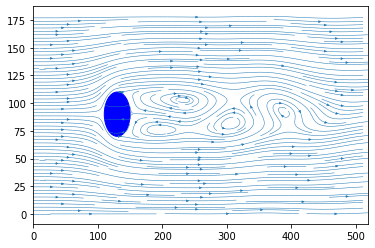

In [59]:
# Create streamline figure        
x = np.arange(0, 520)
y = np.arange(0, 180)
X, Y = np.meshgrid(x, y)
w = u[0,:,:].transpose()
v = u[1,:,:].transpose()
circle = plt.Circle((cx, cy), r, color='blue')
fig, ax = plt.subplots() 
ax.add_artist(circle)
d = 2
plt.streamplot(x, y, w, v, density=d, linewidth=1/d, arrowsize=1/d)
plt.savefig('streamlines0.png', bbox_inches='tight', dpi = 200)
plt.show()

## Time vs Iter graph

Stored 'iterl' (ndarray)
Stored 'timel' (ndarray)


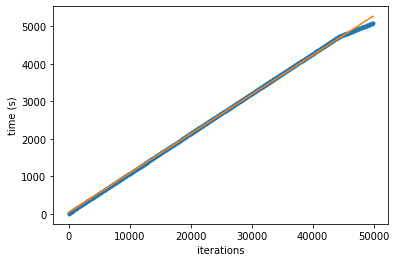

In [707]:
# Data for time graph
%store iterl
%store timel
# Applying a linear fit with polyfit
b, m = polyfit(iterl, timel, 1)
plt.xlabel('iterations')
plt.ylabel('time (s)')
plt.plot(iterl, timel, '.')
plt.plot(iterl, b + m * iterl, '-')
plt.savefig('timeiter.png', dpi=200)
plt.show()